In [6]:
# The datasets library provides tools for easily accessing and working with a wide variety of datasets in various formats (text, images, audio, etc.). It's particularly useful for machine learning and natural language processing tasks.

!pip install datasets

In [8]:
# The torchvision and torchaudio packages provide essential tools for working with image and audio data in PyTorch.

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

ds = load_dataset("marmal88/skin_cancer")

# Use pre-split train, validation, and test sets
train_data = ds["train"]
val_data = ds["validation"]
test_data = ds["test"]

In [8]:
print(train_data)

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})


In [12]:
# Define data transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal flip only
    transforms.RandomRotation(20),  # Rotate within ±20 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
class SkinLesionDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        if not data:
            raise ValueError("Dataset cannot be empty")
        self.data = data
        self.transform = transform
        # Ensure consistent label mapping
        self.label_mapping = {
            label: idx for idx, label in enumerate(
                sorted(set(example['dx'] for example in data))
            )
        }
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise IndexError("Index out of range")
            
        try:
            image = self.data[idx]["image"]
            label = self.label_mapping[self.data[idx]["dx"]]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
            
        except KeyError as e:
            raise KeyError(f"Missing required key in data: {e}")
        except Exception as e:
            raise Exception(f"Error processing item {idx}: {e}")

In [16]:
# Create dataset objects
train_dataset = SkinLesionDataset(train_data, transform=transform)
val_dataset = SkinLesionDataset(val_data, transform=transform)
test_dataset = SkinLesionDataset(test_data, transform=transform)

In [18]:
# Data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
!pip install timm

In [2]:
import timm
timm.list_models(pretrained = True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [20]:
model = timm.create_model("levit_conv_128s.fb_dist_in1k", pretrained=True,num_classes=len(set(train_data['dx'])))


In [22]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
print(next(model.parameters()).device)

cuda:0


In [26]:


# Loss function and optimizer
from torch.optim.lr_scheduler import OneCycleLR  # Import OneCycleLR
train_labels_numeric = [train_dataset.label_mapping[label] for label in train_data['dx']]
class_counts = torch.bincount(torch.tensor(train_labels_numeric))
class_weights = (1.0 / class_counts.float())  
class_weights = class_weights / class_weights.sum()  # Normalize weights

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# AdamW optimizer with weight decay
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-3, weight_decay=1e-4
)

num_epochs = 75
total_steps = num_epochs * len(train_loader)  # Calculate total steps correctly


# One-Cycle Learning Rate scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,  # Use total_steps instead of steps_per_epoch
    pct_start=0.3,
    anneal_strategy='cos',
    cycle_momentum=False,
)


In [28]:
pip install datetime

Note: you may need to restart the kernel to use updated packages.


In [30]:
from datetime import datetime

# Training loop with validation accuracy monitoring and training loss display

best_val_acc = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()  # Adjust learning rate
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    # Calculate average loss and accuracy for the epoch   
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f},Learning Rate: {current_lr:.6f}')
   
    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        torch.save(model.state_dict(), f'levit_conv_128s.fb_dist_in1k_256_Run1_Best_Model_epoch{epoch+1}_valacc{val_acc:.2f}_{timestamp}.pth')
        print(f"levit_conv_128s.fb_dist_in1k_256_Run1 Best model saved at epoch {epoch+1} with validation accuracy: {best_val_acc:.4f}%")

print("Training complete.")

Epoch [1/75], Training Loss: 1.9268, Training Accuracy: 14.8481, Validation Loss: 1.9129, Validation Accuracy: 18.3788,Learning Rate: 0.000045
levit_conv_128s.fb_dist_in1k_256_Run1 Best model saved at epoch 1 with validation accuracy: 18.3788%
Epoch [2/75], Training Loss: 1.8845, Training Accuracy: 21.0922, Validation Loss: 1.9081, Validation Accuracy: 21.0674,Learning Rate: 0.000059
levit_conv_128s.fb_dist_in1k_256_Run1 Best model saved at epoch 2 with validation accuracy: 21.0674%
Epoch [3/75], Training Loss: 1.8530, Training Accuracy: 25.0914, Validation Loss: 1.8746, Validation Accuracy: 24.1172,Learning Rate: 0.000082
levit_conv_128s.fb_dist_in1k_256_Run1 Best model saved at epoch 3 with validation accuracy: 24.1172%
Epoch [4/75], Training Loss: 1.8165, Training Accuracy: 27.1797, Validation Loss: 1.8894, Validation Accuracy: 20.3451,Learning Rate: 0.000113
Epoch [5/75], Training Loss: 1.7981, Training Accuracy: 28.9652, Validation Loss: 1.8429, Validation Accuracy: 28.6918,Learni

In [36]:
torch.save(model.state_dict(),'levit_conv_128s.fb_dist_in1k_256_Run1_Final_model_3.pth')

Test Loss: 0.0803, Test Accuracy: 97.43%


<Figure size 800x600 with 0 Axes>

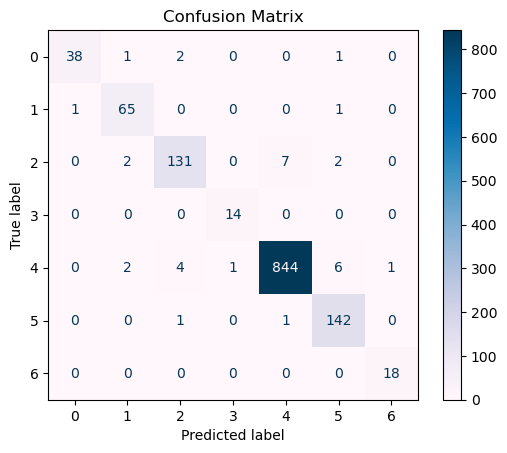

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize test variables
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

# Initialize placeholders for predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        # Collect predictions and true labels for the confusion matrix
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.PuBu, values_format='d')
plt.title('Confusion Matrix')
plt.show()
